

# Lab | Making predictions with logistic regression

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

### Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). 
2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our **TARGET** (y) variable.
3. Read the data into a Pandas dataframe.  At this point you should have 1000 rows.  Number of columns depends on the number of features you chose.
4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
6. Evaluate the results.


In [120]:
import pymysql 
from sqlalchemy import create_engine
import pandas as pd
import datetime
import getpass  
password = getpass.getpass()

········


In [121]:
# first create the engine to access sakila db

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)


In [122]:
# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model.
# It should include some film features and some rental features (X).

film = pd.read_sql_table('film', engine)
display(film.head())

rental = pd.read_sql_table('rental', engine)
display(rental.head())

#first we take a look at the different columns of tables film and rental 

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"{Deleted Scenes, Trailers}",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"{Deleted Scenes, Trailers}",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"{Commentaries, Behind the Scenes}",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,{Deleted Scenes},2006-02-15 05:03:42


/Users/Ana/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:1779: SAWarning: Did not recognize type 'geometry' of column 'location'
  tbl = Table(


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53


In [123]:
#and not we chose the different features we want to keep from both tables: 
# title, rental_rate, length, rating, rental_date and category

query_data = """
SELECT f.title, f.rental_rate, f.length, f.rating, r.rental_date, c.name as category
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id

"""

df = pd.read_sql_query(query_data, engine)

df

,title,rental_rate,length,rating,rental_date,category
0,AMADEUS HOLY,0.99,113,PG,2005-08-02 01:16:59,Action
1,AMADEUS HOLY,0.99,113,PG,2005-08-18 04:26:54,Action
2,AMADEUS HOLY,0.99,113,PG,2005-06-20 20:35:28,Action
3,AMADEUS HOLY,0.99,113,PG,2005-07-09 05:01:58,Action
4,AMADEUS HOLY,0.99,113,PG,2005-07-30 08:02:39,Action
...,...,...,...,...,...,...
16040,WORKING MICROCOSMOS,4.99,74,R,2005-05-30 18:45:17,Travel
16041,WORKING MICROCOSMOS,4.99,74,R,2005-06-15 09:03:52,Travel
16042,WORKING MICROCOSMOS,4.99,74,R,2005-07-07 06:38:31,Travel
16043,WORKING MICROCOSMOS,4.99,74,R,2005-07-30 00:12:41,Travel


In [124]:
# 2 and 3. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) 
# in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

query_may = '''
SELECT f.title,
       MIN(r.rental_date) AS rental_date,
       c.name AS category,
       CASE WHEN YEAR(MIN(r.rental_date)) = 2005 AND MONTH(MIN(r.rental_date)) = 5
            THEN True
            ELSE False
       END AS rented_in_may,
       f.length,
       f.rental_rate,
       f.rating
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY f.title, c.name, f.length, f.rental_rate, f.rating;
'''

rental_may = pd.read_sql_query(query_may, engine)
rental_may


,title,rental_date,category,rented_in_may,length,rental_rate,rating
0,AMADEUS HOLY,2005-05-28 12:08:37,Action,1,113,0.99,PG
1,AMERICAN CIRCUS,2005-05-25 21:58:58,Action,1,129,4.99,R
2,ANTITRUST TOMATOES,2005-05-31 16:48:43,Action,1,168,2.99,NC-17
3,BAREFOOT MANCHURIAN,2005-05-26 20:57:00,Action,1,129,2.99,G
4,BERETS AGENT,2005-05-29 23:37:00,Action,1,77,2.99,PG-13
...,...,...,...,...,...,...,...
953,VALENTINE VANISHING,2005-05-25 19:30:46,Travel,1,48,0.99,PG-13
954,WINDOW SIDE,2005-06-15 03:50:36,Travel,0,85,2.99,R
955,WOLVES DESIRE,2005-06-15 06:54:53,Travel,0,55,0.99,NC-17
956,WORKER TARZAN,2005-06-20 17:26:05,Travel,0,139,2.99,R


In [125]:
# 4. Analyze extracted features (X) and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

# first we check for NaN values
rental_may.isna().sum() 

title            0
rental_date      0
category         0
rented_in_may    0
length           0
rental_rate      0
rating           0
dtype: int64

In [126]:
rental_may.dtypes 
#check data types

title                    object
rental_date      datetime64[ns]
category                 object
rented_in_may             int64
length                    int64
rental_rate             float64
rating                   object
dtype: object

In [127]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# importing libraries to check later the data


In [128]:
#now we divide into numerical and categorical
numerical = rental_may.select_dtypes(include = np.number) 
categorical = rental_may.select_dtypes([object])
display(numerical)
display(categorical)

#date is not included in either set

,rented_in_may,length,rental_rate
0,1,113,0.99
1,1,129,4.99
2,1,168,2.99
3,1,129,2.99
4,1,77,2.99
...,...,...,...
953,1,48,0.99
954,0,85,2.99
955,0,55,0.99
956,0,139,2.99


,title,category,rating
0,AMADEUS HOLY,Action,PG
1,AMERICAN CIRCUS,Action,R
2,ANTITRUST TOMATOES,Action,NC-17
3,BAREFOOT MANCHURIAN,Action,G
4,BERETS AGENT,Action,PG-13
...,...,...,...
953,VALENTINE VANISHING,Travel,PG-13
954,WINDOW SIDE,Travel,R
955,WOLVES DESIRE,Travel,NC-17
956,WORKER TARZAN,Travel,R


In [129]:
#now we check if there is class imbalance in the categorical variables by checking how many of each values are there

rental_may['category'].value_counts(dropna=False)


Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Children       58
Games          58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category, dtype: int64

In [130]:
data_may['rating'].value_counts(dropna=False)
# also seems well distributed

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

In [131]:
#rented_in_may is numerical but also belongs in categorical as it is a yes/no option. 
numerical.describe()


,rented_in_may,length,rental_rate
count,958.000000,958.000000,958.000000
mean,0.716075,115.490605,2.977474
std,0.451136,40.471844,1.643152
min,0.000000,46.000000,0.990000
25%,0.000000,80.250000,0.990000
50%,1.000000,114.000000,2.990000
75%,1.000000,150.000000,4.990000
max,1.000000,185.000000,4.990000


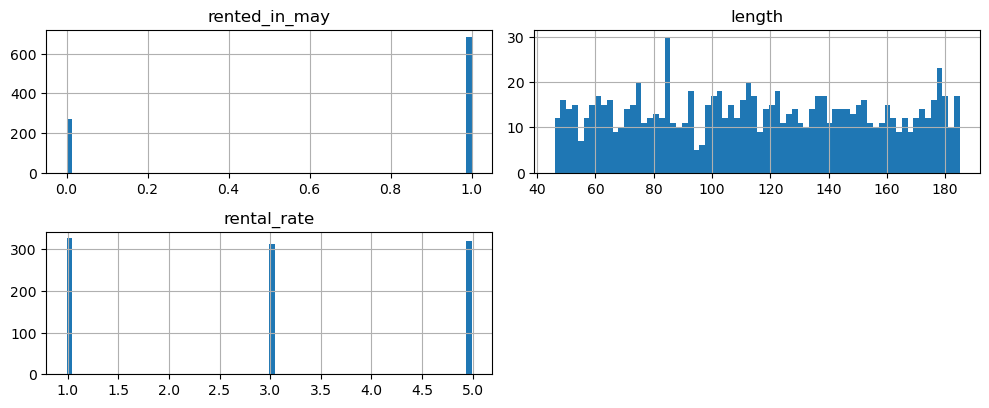

In [132]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=70,ax=ax,figsize=(10,10))
        ax.set_title(var_name)
     
    fig.tight_layout()  
    plt.show()

draw_histograms(numerical, numerical.columns, 5, 2) 


In [133]:
numerical['rented_in_may'].value_counts(dropna=False)

#here there is a class imbalance

1    686
0    272
Name: rented_in_may, dtype: int64

In [134]:
rental_may['rental_rate'] = rental_may['rental_rate'].astype('object') #change it to categoricals in the main dataframe

In [135]:
numerical['rental_rate'].value_counts(dropna=False)
# rental_rate is the price, there are only three values but well distributed so there isnt class imbalance

0.99    326
4.99    320
2.99    312
Name: rental_rate, dtype: int64

In [136]:
#4. Analyze extracted features (X) and transform them. 
# You may need to encode some categorical variables, or scale numerical variables.

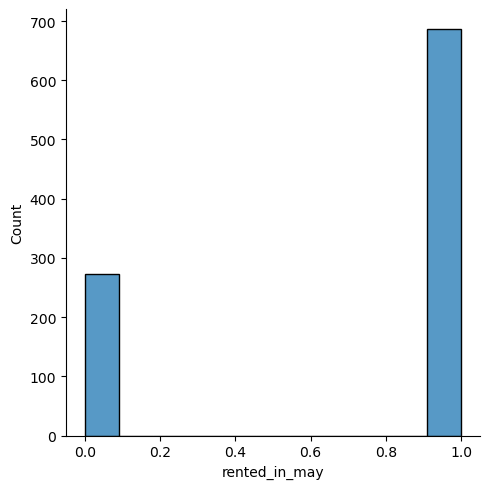

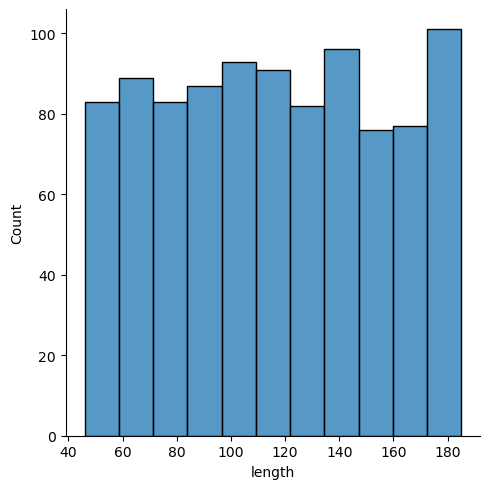

In [137]:

def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df[col])
        plt.show()

plot_distributions(rental_may)        


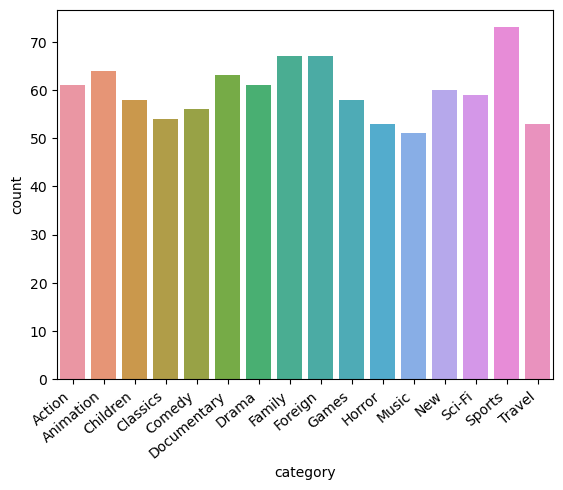

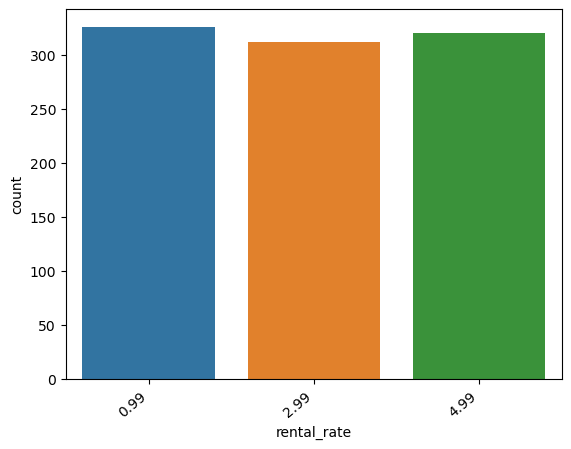

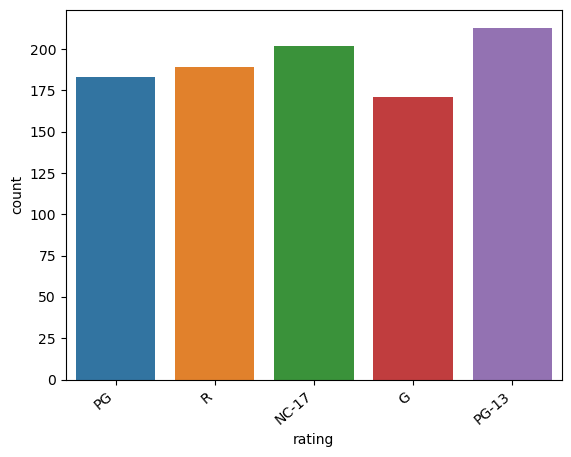

In [138]:

def cat_distributions(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    # Remove 'title' 
    cat_cols.remove('title')

    for col in cat_cols:
        ax = sns.countplot(data=df, x=col)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.show()
        
cat_distributions(rental_may)

In [139]:
# split into train and test sets as well as column to predict (y) and used to predict (X)

y = rental_may['rented_in_may']
X = rental_may.drop('rented_in_may', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [140]:
X_train

,title,rental_date,category,length,rental_rate,rating
302,CHICKEN HELLFIGHTERS,2005-05-25 23:34:22,Documentary,122,0.99,PG
467,RANGE MOONWALKER,2005-05-28 14:27:51,Family,147,4.99,PG
294,ADAPTATION HOLES,2005-05-31 04:50:07,Documentary,50,2.99,NC-17
548,WASH HEAVENLY,2005-05-26 04:49:17,Foreign,161,4.99,R
465,PRIX UNDEFEATED,2005-05-29 08:35:49,Family,115,2.99,R
...,...,...,...,...,...,...
106,POTTER CONNECTICUT,2005-05-31 05:53:00,Animation,115,2.99,PG
270,MYSTIC TRUMAN,2005-05-24 23:08:07,Comedy,92,0.99,NC-17
860,INSTINCT AIRPORT,2005-05-31 16:07:09,Sports,116,2.99,PG
435,DUMBO LUST,2005-07-07 20:46:45,Family,119,0.99,NC-17


In [141]:
#now we use minmaxscaler to transform the numerical data

import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num) 

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_minmax = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_test_minmax  = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)

In [142]:
X_train_norm_df.describe()

,length
count,766.000000
mean,0.503081
std,0.290325
min,0.000000
25%,0.251799
50%,0.489209
75%,0.748201
max,1.000000


In [143]:
# we will drop the title column from X sets because we cannot use it to predict as they are all different (like an id column)

X_train = X_train.drop(['title'], axis=1)
X_test = X_test.drop(['title'], axis=1)


In [144]:
#now we use onehotencoder for our categorical sets

X_train_cat = X_train.select_dtypes('object')
X_test_cat  = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first')
encoder.fit(X_train_cat)

X_train_cat_np = encoder.transform(X_train_cat).toarray()
X_test_cat_np  = encoder.transform(X_test_cat).toarray()

X_train_cat_onehot = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out())
X_test_cat_onehot  = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out())

In [145]:
display(X_train_cat_onehot.head())
display(X_test_cat_onehot.head())


,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [147]:
# now we have a full dataframe that is already normalized and we can work with, so we concatenate it again the cat and num dataframes

X_train_trans = pd.concat([X_train_minmax, X_train_cat_onehot], axis=1)
X_test_trans = pd.concat([X_test_minmax, X_test_cat_onehot], axis=1)

display(X_train_trans.head())
display(X_test_trans.head())

,length,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.546763,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.726619,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.028777,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.827338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.496403,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,length,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,...,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.208633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.043165,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.762590,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.100719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.582734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [148]:
# 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')

logreg.fit(X_train_trans, y_train)

LogisticRegression(multi_class='multinomial', random_state=42)

In [150]:
y_test_pred1 = logreg.predict(X_test_trans)
print(y_test_pred1)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


In [151]:
# now we evaluate the model 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

print("Accuracy (test set): {:.2f}".format(accuracy_score(y_test,y_test_pred1)))
print("Precision (test set): {:.2f}".format(precision_score(y_test,y_test_pred1)))
print("Recall (test set): {:.2f}".format(recall_score(y_test,y_test_pred1)))
print("F1 (test set): {:.2f}".format(f1_score(y_test,y_test_pred1)))
print("Kappa (test set): {:.2f}".format(cohen_kappa_score(y_test,y_test_pred1)))

Accuracy (test set): 0.69
Precision (test set): 0.69
Recall (test set): 1.00
F1 (test set): 0.82
Kappa (test set): 0.00


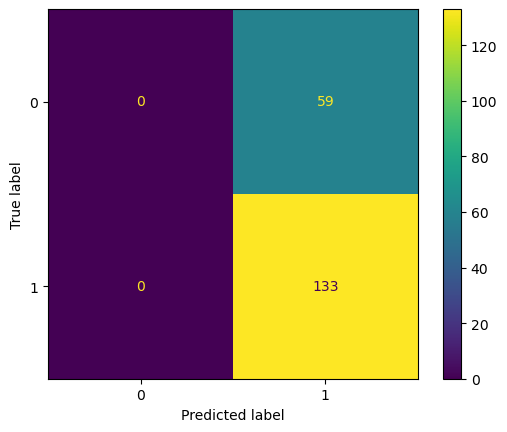

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test1 = confusion_matrix(y_test,y_test_pred1) # real and predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test1, display_labels=logreg.classes_) # labels of the classes
disp.plot()
plt.show()

In [154]:
# 6. Evaluate the results.

# well it doesnt seem to be very good for a model as the kappa is 1, 
# this is caused by a high class imbalance between the 1 and 0 in the rented_in_may column